In [280]:
import pandas as pd
from textwrap import wrap
from matplotlib import rcParams
from matplotlib import cm
data = pd.read_csv('../processed_data/genesMappingPW.csv')

In [281]:
data.head()

,gene,pathways
0,SSA1,"['sce03040 Spliceosome', 'sce04141 Protein p..."
1,MDM10,['sce04139 Mitophagy - yeast']
2,CYS3,"['sce00260 Glycine, serine and threonine meta..."
3,SYN8,['sce04130 SNARE interactions in vesicular tr...
4,NTG1,['sce03410 Base excision repair']


In [282]:
data.pathways = data.pathways.apply(lambda x: eval(x))

In [283]:
import numpy as np
discreteP = np.hstack(data.pathways)
discreteP

array(['sce03040  Spliceosome',
       'sce04141  Protein processing in endoplasmic reticulum',
       'sce04144  Endocytosis', ..., 'sce01100  Metabolic pathways',
       'sce00470  D-Amino acid metabolism',
       'sce01100  Metabolic pathways'], dtype='<U64')

In [284]:
len(discreteP)

3939

In [285]:
len(data.gene)

1708

In [286]:
fiData = pd.read_excel('../raw_data/41592_2018_45_MOESM4_ESM.xlsx', skiprows=6, engine='openpyxl')
fiData = fiData.rename(columns={'Standard Name': 'gene'})[['gene', 'intensity']].dropna(axis=0)

/home/vaslem/.local/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [287]:
fiData.head()

,gene,intensity
0,SSA1,11.906396
1,ERP2,0.299776
2,FUN14,0.455914
3,SPO7,0.027090
5,SWC3,0.031941


In [288]:
from sklearn.cluster import KMeans
clusterLabels = KMeans(n_clusters=10).fit_predict(fiData['intensity'].values.reshape(-1, 1))
fiData['cluster'] = clusterLabels

In [289]:
fiData.clusterLabels = clusterLabels
visData = pd.merge(data, fiData, on='gene')
visData = visData.explode('pathways')
visData.head()

<ipython-input-289-6380f5c6341d>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  fiData.clusterLabels = clusterLabels


,gene,pathways,intensity,cluster
0,SSA1,sce03040 Spliceosome,11.906396,5
0,SSA1,sce04141 Protein processing in endoplasmic re...,11.906396,5
0,SSA1,sce04144 Endocytosis,11.906396,5
0,SSA1,sce04213 Longevity regulating pathway - multi...,11.906396,5
1,CYS3,"sce00260 Glycine, serine and threonine metabo...",0.583592,9


In [290]:
visData.shape

(3916, 4)

In [291]:
visData[visData['cluster'] == 0]

,gene,pathways,intensity,cluster
2,SYN8,sce04130 SNARE interactions in vesicular tran...,0.010805,0
3,NTG1,sce03410 Base excision repair,0.013591,0
5,CCR4,sce03018 RNA degradation,0.121578,0
7,LTE1,sce04111 Cell cycle - yeast,0.006595,0
8,PRP45,sce03040 Spliceosome,0.018428,0
...,...,...,...,...
1691,RPO26,sce03020 RNA polymerase,0.176414,0
1692,SKI3,sce03018 RNA degradation,0.077215,0
1693,RPC82,sce03020 RNA polymerase,0.038728,0
1695,HPA2,sce00470 D-Amino acid metabolism,0.008966,0


In [292]:
visData.pathways = visData.pathways.apply(lambda x: ' '.join(x.split(' ')[1:]) )
visData.head()

,gene,pathways,intensity,cluster
0,SSA1,Spliceosome,11.906396,5
0,SSA1,Protein processing in endoplasmic reticulum,11.906396,5
0,SSA1,Endocytosis,11.906396,5
0,SSA1,Longevity regulating pathway - multiple species,11.906396,5
1,CYS3,"Glycine, serine and threonine metabolism",0.583592,9


In [293]:

freq = visData.groupby('pathways')['gene'].count()
freq

pathways
 2-Oxocarboxylic acid metabolism                28
 ABC transporters                               16
 Alanine, aspartate and glutamate metabolism    24
 Amino sugar and nucleotide sugar metabolism    28
 Aminoacyl-tRNA biosynthesis                    32
                                                ..
 Various types of N-glycan biosynthesis         27
 Vitamin B6 metabolism                           8
 alpha-Linolenic acid metabolism                 4
 beta-Alanine metabolism                        12
 mRNA surveillance pathway                      40
Name: gene, Length: 117, dtype: int64

In [294]:
freq = freq.sort_values(ascending=False)
freq.name = 'count'

In [295]:
freq.to_excel('../processed_data/known_genes_pathways_frequency.xlsx')

In [296]:
freq.iloc[:10]

pathways
 Metabolic pathways                             653
 Biosynthesis of secondary metabolites          295
 Cell cycle - yeast                             113
 Biosynthesis of cofactors                      112
 Meiosis - yeast                                112
 Biosynthesis of amino acids                    105
 Carbon metabolism                               95
 MAPK signaling pathway - yeast                  94
 Ribosome                                        93
 Protein processing in endoplasmic reticulum     84
Name: count, dtype: int64

In [297]:
notIncluded

,cluster,gene
67,6,RPL41B
68,6,TDH2
72,6,ALD6
75,6,ADH4
77,6,PGM2
...,...,...
1751,0,IMA3
1752,0,DAL2
1753,0,MPS1
1754,0,FLO11


In [298]:
# keep the 10 most frequent pathways
visDataSubset = visData[visData['pathways'].isin(freq.iloc[:10].index)]
visDataSubset = visDataSubset.sort_values('intensity', ascending=False)
cDescriptions = visDataSubset.groupby('cluster')['gene'].agg(
    lambda x: ','.join([y.strip() for y in list(dict.fromkeys(x))])[:96].split(','))
cDescriptions.name = 'desc'
included = cDescriptions.explode()
included.name = 'gene'
included = included.reset_index()
included = visDataSubset.merge(included, on=['gene', 'cluster'], how='outer', indicator=True)
notIncluded = included[included._merge == 'left_only']
notIncluded = notIncluded[['cluster','gene']].drop_duplicates()
notIncludedCnts = notIncluded.groupby('cluster')['gene'].agg('count')

In [299]:
notIncludedCnts

cluster
0    627
2     25
4     74
7     60
8      8
9    156
Name: gene, dtype: int64

In [300]:
shownInDesc = cDescriptions.explode()
shownInDesc

cluster
0     IMG1
0     OST5
0     MET7
0    PRM15
0     CYC8
     ...  
9    HEM15
9     EMI2
9     IMD4
9     RPE1
9    URA10
Name: desc, Length: 121, dtype: object

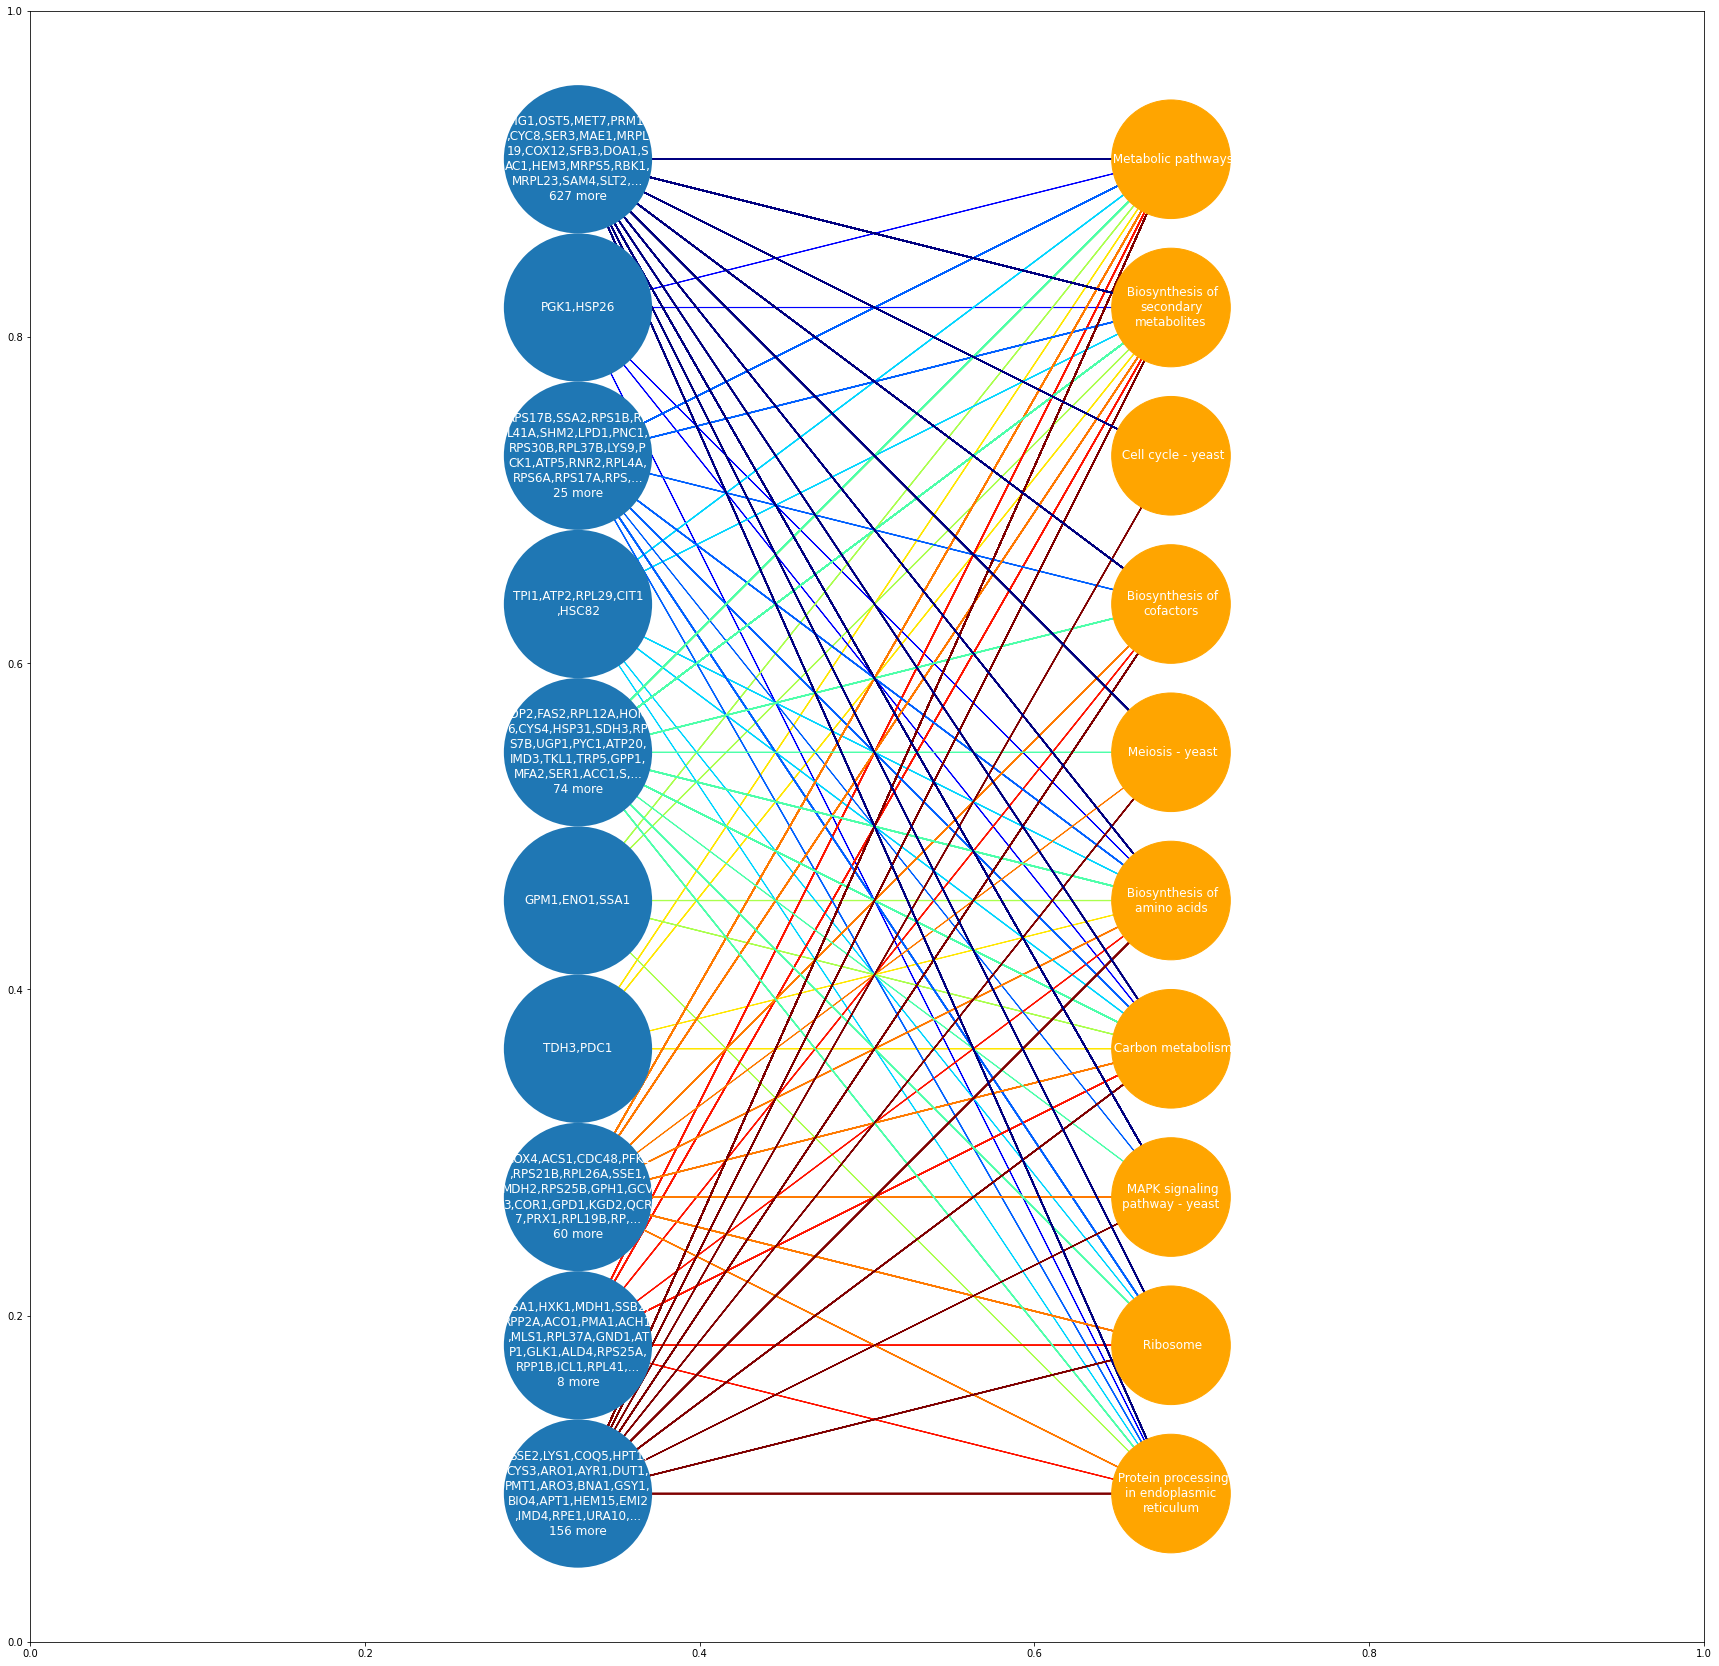

In [310]:

import matplotlib.pyplot as plt
 
fig, ax = plt.subplots()

ax = fig.add_subplot(111)

x = 0
y = 0

gradient = np.linspace(0, 1, 10)
path_coords = {}
clusters_coords = {}
rgb = cm.get_cmap('jet')(gradient)[np.newaxis, :, :3]
for cluster in range(9,-1,-1):
    y += 50
    clusters_coords[cluster] = y
y = 0
for path in range(9,-1,-1):
    y += 50
    path_coords[path] = y
    
for _, line in visDataSubset.iterrows():
    
    gradient[line['cluster']]
    plt.arrow(x=0, y=clusters_coords[line['cluster']], color=rgb[:, line['cluster'], :].flatten(),
              dx=200, dy=path_coords[np.where(freq.index == line['pathways'])[0][0]] - clusters_coords[line['cluster']], width=.06)
    
    
    

for cluster in range(9,-1,-1):
    y = clusters_coords[cluster]
    circle = plt.Circle((x, y), radius=25)
    ax.add_patch(circle)
    ax.annotate('\n'.join(wrap(','.join(cDescriptions[cluster]) + 
                               
                               (f',...{notIncludedCnts[cluster]} more' if cluster in notIncludedCnts else '')
                               
                               , width=20)), xy=(x, y), fontsize=12, 
                verticalalignment='center', horizontalalignment='center', color='white')

x = 200

for path in range(9,-1,-1):
    y = path_coords[path]
    circle = plt.Circle((x, y), radius=20, color='orange')
    ax.add_patch(circle)
    ax.annotate('\n'.join(wrap(freq.index[path], width=20)), xy=(x, y), fontsize=12, 
                verticalalignment='center', horizontalalignment='center', color='white')

ax.axis('off')
ax.set_aspect('equal')
ax.autoscale_view()

plt.show()

In [314]:
fig.savefig("../figures/pathways_mapping.png")